# Housing Sales Prices & Venues in Düsseldorf

## A. Introduction

### A.1. Description & Disscusion of the Background

This project is part of the final course of the IBM Data Science professional certificate: **Applied Data Science Capstone**. 
Duesseldorf is the 6th largest city in Germany. With a population of 600.000 citizens, it is home to a large community of immigrants. One person out of 6 currently living in Duesseldorf was born outside of Germany. It is one of the reasons why we chose to relocate here with my wife.

The city is divided in ten regions, called _'Bezirk'_, which are also divided in smaller regions, neighborhoods, called _'Stadtteil'_.

One of the first things we noticed when we moved to Germany, is that there is a **huge** amount of Flower stores, and that people consumes Ice Cream even during really cold days. These two things are radically different from where we come from. So, while thinking about topics for the current project, it occurred to us to try to figure out **if there is a correlation between the amount of Ice Cream and Flower Sale Venues with the Property prices in every _Stadtteil_ in Duesseldorf?**
To answer that question will be main objective of this project


### A.2. Data Description

There are two main sources of the data

1. A wikipedia table containing information about the city of Duesseldorf 
2. A table built with the range of costs per square meter of Apartments in every _Stadtteil_

The rest of the information will be adquired through different means as the project advances. 


## B. Methodology

### B.1. Installing the necessary packages and importing the required libraries 

In [2]:
#!conda install -c conda-forge folium=0.7.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#!pip install BeautifulSoup4
#!pip install geopy

print('ready')

ready


In [3]:
import pandas as pd 
import numpy as np
import requests
import json
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import io
import folium
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

print('ready')

ready


### B.2. Creating data table and data pre-processing

The next step is to adquire the table from Wikipedia, add it as a Dataframe, __df__, remove the unnecessary rows and other details that help with the handling and presentation of the data.


In [4]:
url = 'https://de.wikipedia.org/wiki/Liste_der_Stadtteile_von_D%C3%BCsseldorf'
data  = requests.get(url).text 
soup = BeautifulSoup(data,"html5lib")
table = soup.find('table')
df = pd.read_html(str(table))[0]
df.drop(columns=['Fläche','Bevölkerungsdichte','Eingemeindet','K','Karte'], axis=1, inplace=True)
headers=['Stadtteil','Stadtbezirk','Einwohner']
df.columns=headers
df = df[['Stadtbezirk','Stadtteil','Einwohner']]
df['Stadtteil']=df['Stadtteil'].str.rstrip(']1234567890[] ')
df.iat[23, 1] = 'Hubbelrath'
df['Stadtbezirk'] = df['Stadtbezirk'].map(lambda x: str(x)[5:])
df['Einwohner']=df['Einwohner'].str.lstrip('0')
df['Einwohner']=df['Einwohner'].str.replace(".","")
df['Einwohner']=df['Einwohner'].str.replace(" ","")
df['Einwohner']= df['Einwohner'].astype(int)
df.head()

,Stadtbezirk,Stadtteil,Einwohner
0,1,Altstadt,1906
1,5,Angermund,6061
2,9,Benrath,15772
3,3,Bilk,37275
4,1,Carlstadt,2210


In [5]:
df.shape

(50, 3)

It is time to import the table with the range of costs per square meter of Apartments in every _Stadtteil_ from my Github repository, as a Dataframe **dfC**. 

In [6]:
csv='https://raw.githubusercontent.com/ppoblete88/Coursera_Capstone/master/Duesseldorf%20st%20cost.csv'
dfC = pd.read_csv(csv)
dfC.head()

,Stadtteil,Cost Binned,Cost per sm in Euro
0,Altstadt,M,2000 to 2400
1,Angermund,H,2400 to 3000
2,Benrath,M,2000 to 2400
3,Bilk,M,2000 to 2400
4,Carlstadt,VH,3000 to 4700


This data will be merged with the previous Dataframe and the _'Cost Binned'_ column will be modified.
It is important to notice that at this point some _Stadtteil_ will be removed because it does not provide with any result later on.

In [7]:
df = df.merge(dfC, how='left', on='Stadtteil')
df['Cost Binned']=df['Cost Binned'].str.replace("V","Very ")
df['Cost Binned']=df['Cost Binned'].str.replace("H","High")
df['Cost Binned']=df['Cost Binned'].str.replace("M","Medium")
df['Cost Binned']=df['Cost Binned'].str.replace("L","Low")
df.drop([6,23],inplace=True)
df.reset_index(drop=True,inplace=True)
df.head()

,Stadtbezirk,Stadtteil,Einwohner,Cost Binned,Cost per sm in Euro
0,1,Altstadt,1906,Medium,2000 to 2400
1,5,Angermund,6061,High,2400 to 3000
2,9,Benrath,15772,Medium,2000 to 2400
3,3,Bilk,37275,Medium,2000 to 2400
4,1,Carlstadt,2210,Very High,3000 to 4700


In [8]:
df.shape

(48, 5)

### B.3. Visual Map of _Stadtteil_

The first step to create a visual map with Folium is to obtain the coordinates of the city of Duesseldorf

In [9]:
address = 'Düsseldorf, NRW'

geolocator = Nominatim(user_agent="Duesseldorf_explorer")
location = geolocator.geocode(address)
latitudeD = location.latitude
longitudeD = location.longitude
print('The geograpical coordinate of Düsseldorf are {}, {}.'.format(latitudeD, longitudeD))

The geograpical coordinate of Düsseldorf are 51.2254018, 6.7763137.


**Now is important to also obtain the coordinates of every *Stadteil* and add that to the Dataframe**

In [10]:
for index, row in df.iterrows():
    address = row['Stadtteil'],'Düsseldorf, NRW'

    geolocator = Nominatim(user_agent="Duesseldorf_explorer")
    location = geolocator.geocode(address)
    df.at[index,'Latitude'] = location.latitude
    df.at[index,'Longitude'] = location.longitude
df.head()

,Stadtbezirk,Stadtteil,Einwohner,Cost Binned,Cost per sm in Euro,Latitude,Longitude
0,1,Altstadt,1906,Medium,2000 to 2400,51.225912,6.773567
1,5,Angermund,6061,High,2400 to 3000,51.328995,6.781416
2,9,Benrath,15772,Medium,2000 to 2400,51.163479,6.872734
3,3,Bilk,37275,Medium,2000 to 2400,51.202758,6.785101
4,1,Carlstadt,2210,Very High,3000 to 4700,51.222142,6.773394


The final part of this section now is to produce the map with every _Stadtteil_

In [11]:
map_Duess = folium.Map(location=[latitudeD, longitudeD], zoom_start=11)

# add markers to map
for lat, lng, bez, teil in zip(df['Latitude'], df['Longitude'], df['Stadtbezirk'], df['Stadtteil']):
    label = '{}, {}'.format(teil, bez)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_Duess)  
    
map_Duess

### B.4. Clustering of _Stadtteil_

In this section I will use the foursquare API to search for venues in every *Stadtteil*. Like I mentioned before, there is one that does not return any venue, so it was removed. The first part is to insert my Credentials.

In [12]:
CLIENT_ID = 'M4OMBJXZNTPK5DYBCC33ZYGBBO1ROLVCN332XG5FPH1IQXDU' # your Foursquare ID
CLIENT_SECRET = 'AM4GDTGWY413XFEWFLPMJ0FC5H5WQRIRB5Y1WYT5PEFE00NS' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: M4OMBJXZNTPK5DYBCC33ZYGBBO1ROLVCN332XG5FPH1IQXDU
CLIENT_SECRET:AM4GDTGWY413XFEWFLPMJ0FC5H5WQRIRB5Y1WYT5PEFE00NS


I will use a function to obtain the Venues

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Stadtteil', 
                  'Stadtteil Latitude', 
                  'Stadtteil Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Venues are available for the *Stadtteile* showed underneath

In [14]:
Duess_venues = getNearbyVenues(names=df['Stadtteil'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Altstadt
Angermund
Benrath
Bilk
Carlstadt
Derendorf
Eller
Flehe
Flingern Nord
Flingern Süd
Friedrichstadt
Garath
Gerresheim
Golzheim
Grafenberg
Hafen
Hamm
Hassels
Heerdt
Hellerhof
Himmelgeist
Holthausen
Itter
Kaiserswerth
Kalkum
Knittkuhl
Lörick
Lichtenbroich
Lierenfeld
Lohausen
Ludenberg
Mörsenbroich
Niederkassel
Oberbilk
Oberkassel
Pempelfort
Rath
Reisholz
Stadtmitte
Stockum
Unterbach
Unterbilk
Unterrath
Urdenbach
Vennhausen
Volmerswerth
Wersten
Wittlaer


Let's see how many Venues are for every Area. Some reach the 100 Venues limit, while other have as little as 1 venue available

In [15]:
Duess_venues.groupby('Stadtteil').count()

,Stadtteil Latitude,Stadtteil Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Stadtteil,,,,,,
Altstadt,100,100,100,100,100,100
Angermund,5,5,5,5,5,5
Benrath,14,14,14,14,14,14
Bilk,22,22,22,22,22,22
Carlstadt,100,100,100,100,100,100
Derendorf,23,23,23,23,23,23
Eller,11,11,11,11,11,11
Flehe,4,4,4,4,4,4
Flingern Nord,38,38,38,38,38,38


Now let's create a table to count the venues by category and Stadtteil

In [16]:
T_onehot = pd.get_dummies(Duess_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
T_onehot['Stadtteil'] = Duess_venues['Stadtteil'] 

# move neighborhood column to the first column
fixed_columns = [T_onehot.columns[-1]] + list(T_onehot.columns[:-1])
T_onehot = T_onehot[fixed_columns]

T_onehot.head()

,Stadtteil,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,...,Trail,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Women's Store,Yoga Studio
0,Altstadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Altstadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Altstadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Altstadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Altstadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Time to see what the probability is that there is a particular venue in a given district

In [17]:
T_grouped = T_onehot.groupby('Stadtteil').mean().reset_index()
T_grouped

,Stadtteil,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,...,Trail,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Women's Store,Yoga Studio
0,Altstadt,0.000000,0.00,0.000000,0.01,0.00,0.000000,0.000000,0.0,0.010000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.03,0.0,0.000000
1,Angermund,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.2,0.000000
2,Benrath,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000
3,Bilk,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.000000,...,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000
4,Carlstadt,0.000000,0.01,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.010000,...,0.000000,0.000000,0.000000,0.010000,0.010000,0.000000,0.000000,0.02,0.0,0.000000
5,Derendorf,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.043478,0.000000,0.043478,0.000000,0.00,0.0,0.000000
6,Eller,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000
7,Flehe,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000
8,Flingern Nord,0.000000,0.00,0.000000,0.00,0.00,0.078947,0.000000,0.0,0.000000,...,0.000000,0.026316,0.000000,0.026316,0.026316,0.052632,0.000000,0.00,0.0,0.000000
9,Flingern Süd,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.00,0.0,0.000000


The next lines of code will create a function to view only the top 10 more common Venues

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Stadtteil']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Stadtteil'] = T_grouped['Stadtteil']

for ind in np.arange(T_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(T_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Stadtteil,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Altstadt,Coffee Shop,Brewery,Hotel,Boutique,Café,German Restaurant,Bar,Plaza,Steakhouse,Ice Cream Shop
1,Angermund,Women's Store,Bus Stop,Light Rail Station,Restaurant,Supermarket,Yoga Studio,Event Service,Food,Flower Shop,Fast Food Restaurant
2,Benrath,Café,Ice Cream Shop,Palace,Fast Food Restaurant,Frozen Yogurt Shop,Museum,Supermarket,Bank,Drugstore,Greek Restaurant
3,Bilk,Tram Station,Hotel,Italian Restaurant,Greek Restaurant,Indian Restaurant,Bakery,Costume Shop,Pub,Doner Restaurant,Café
4,Carlstadt,Boutique,Italian Restaurant,Coffee Shop,Café,Clothing Store,Plaza,German Restaurant,Bakery,Brewery,Furniture / Home Store


It is finally time to group the Stadtteile in clusters

In [22]:
kclusters = 3

T_grouped_clustering = T_grouped.drop('Stadtteil', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(T_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

I checked that the best ammount of clusters was 3, like performed by Sercan Yıldız 

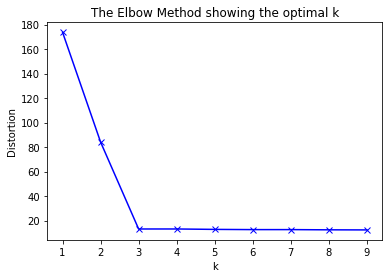

In [21]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(T_grouped_clustering)
    #kmeanModel.fit(istanbul_grouped_clustering)
    distortions.append(sum(np.min(cdist(T_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1)) / T_grouped_clustering.shape[0])

#There are different metric distance function for spatial distance. 
#I choose correlation instaed of euclidean because the canberra function gives me more clear view of elbow break point.

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The next step is to add the data acquired previously to the Dataframe

In [23]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
T_merged = df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
T_merged = T_merged.join(neighborhoods_venues_sorted.set_index('Stadtteil'), on='Stadtteil')

T_merged.head() # check the last columns!

,Stadtbezirk,Stadtteil,Einwohner,Cost Binned,Cost per sm in Euro,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Altstadt,1906,Medium,2000 to 2400,51.225912,6.773567,0,Coffee Shop,Brewery,Hotel,Boutique,Café,German Restaurant,Bar,Plaza,Steakhouse,Ice Cream Shop
1,5,Angermund,6061,High,2400 to 3000,51.328995,6.781416,0,Women's Store,Bus Stop,Light Rail Station,Restaurant,Supermarket,Yoga Studio,Event Service,Food,Flower Shop,Fast Food Restaurant
2,9,Benrath,15772,Medium,2000 to 2400,51.163479,6.872734,0,Café,Ice Cream Shop,Palace,Fast Food Restaurant,Frozen Yogurt Shop,Museum,Supermarket,Bank,Drugstore,Greek Restaurant
3,3,Bilk,37275,Medium,2000 to 2400,51.202758,6.785101,0,Tram Station,Hotel,Italian Restaurant,Greek Restaurant,Indian Restaurant,Bakery,Costume Shop,Pub,Doner Restaurant,Café
4,1,Carlstadt,2210,Very High,3000 to 4700,51.222142,6.773394,0,Boutique,Italian Restaurant,Coffee Shop,Café,Clothing Store,Plaza,German Restaurant,Bakery,Brewery,Furniture / Home Store


**Now I can visualize in a map the three Clusters:**

In [24]:
map_clusters = folium.Map(location=[latitudeD, longitudeD], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(T_merged['Latitude'], T_merged['Longitude'], T_merged['Stadtteil'], T_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### B.5. Comparing cost of Apartments versus Amount of Ice Cream Shops 

The first thing I will try is to get the probability that a store is an Ice Cream Shop for every Stadtteil from the table T_grouped already produced, in a new Dataframe _dfICS_, which will be merged to the main Dataframe, **df**

In [25]:
dfICS=T_grouped[['Stadtteil','Ice Cream Shop']]
df=df.merge(dfICS, how='left',on='Stadtteil')
df.head()

,Stadtbezirk,Stadtteil,Einwohner,Cost Binned,Cost per sm in Euro,Latitude,Longitude,Ice Cream Shop
0,1,Altstadt,1906,Medium,2000 to 2400,51.225912,6.773567,0.030000
1,5,Angermund,6061,High,2400 to 3000,51.328995,6.781416,0.000000
2,9,Benrath,15772,Medium,2000 to 2400,51.163479,6.872734,0.071429
3,3,Bilk,37275,Medium,2000 to 2400,51.202758,6.785101,0.000000
4,1,Carlstadt,2210,Very High,3000 to 4700,51.222142,6.773394,0.020000


Now I will add a column to the **df** with an Average value for the Apartment cost per square meter as *AVG Cost*

In [26]:
for index, row in df.iterrows():
    if row['Cost Binned']=='Very High':
        df.at[index,'AVG Cost'] = 3800
    if row['Cost Binned']=='High':
        df.at[index,'AVG Cost'] = 2700
    if row['Cost Binned']=='Medium':
        df.at[index,'AVG Cost'] = 2200
    if row['Cost Binned']=='Low':
        df.at[index,'AVG Cost'] = 1800
df.head()

,Stadtbezirk,Stadtteil,Einwohner,Cost Binned,Cost per sm in Euro,Latitude,Longitude,Ice Cream Shop,AVG Cost
0,1,Altstadt,1906,Medium,2000 to 2400,51.225912,6.773567,0.030000,2200.0
1,5,Angermund,6061,High,2400 to 3000,51.328995,6.781416,0.000000,2700.0
2,9,Benrath,15772,Medium,2000 to 2400,51.163479,6.872734,0.071429,2200.0
3,3,Bilk,37275,Medium,2000 to 2400,51.202758,6.785101,0.000000,2200.0
4,1,Carlstadt,2210,Very High,3000 to 4700,51.222142,6.773394,0.020000,3800.0


**Finally, let's see if there is a correlation between the probabilty that a *Stadtteil* has an Ice Cream Shop and the Apartment cost in that area. For that purpose, I will plot a regression line between the 2 variables:**

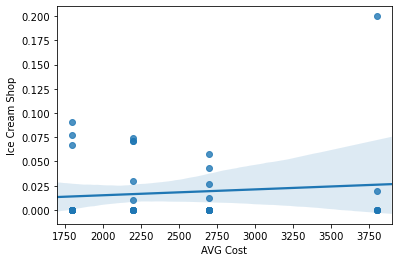

In [28]:
ax=sns.regplot(x='AVG Cost',y='Ice Cream Shop',data=df)

**Well, that doesn't show a correlation.** Maybe it was because I used the *probability* that there is an Ice Cream Shop instead of the *actual* amount of Ice Cream Shops?
Let's obtain that amount from foursquare searching only for Ice Cream Shops

In [29]:
def getNearbyIceCream(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4bf58dd8d48988d1c9941735'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Stadtteil', 
                  'Stadtteil Latitude', 
                  'Stadtteil Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [30]:
ICE_venues = getNearbyIceCream(names=df['Stadtteil'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Altstadt
Angermund
Benrath
Bilk
Carlstadt
Derendorf
Eller
Flehe
Flingern Nord
Flingern Süd
Friedrichstadt
Garath
Gerresheim
Golzheim
Grafenberg
Hafen
Hamm
Hassels
Heerdt
Hellerhof
Himmelgeist
Holthausen
Itter
Kaiserswerth
Kalkum
Knittkuhl
Lörick
Lichtenbroich
Lierenfeld
Lohausen
Ludenberg
Mörsenbroich
Niederkassel
Oberbilk
Oberkassel
Pempelfort
Rath
Reisholz
Stadtmitte
Stockum
Unterbach
Unterbilk
Unterrath
Urdenbach
Vennhausen
Volmerswerth
Wersten
Wittlaer


Let's create an auxiliary Dataframe _df2_ to get the amount of Ice Cream Shops 

In [31]:
df2=ICE_venues.groupby('Stadtteil').count()
df2.reset_index(drop=False,inplace=True)
df2=df2[['Stadtteil','Venue']]
cabezas=['Stadtteil','IC Shops']
df2.columns=cabezas
df2.head()

,Stadtteil,IC Shops
0,Altstadt,11
1,Benrath,3
2,Bilk,2
3,Carlstadt,11
4,Derendorf,1


Now I will merge that to **df** and replace 'NaN' with the number zero

In [32]:
df=df.merge(df2, how='left',on='Stadtteil')
df['IC Shops'].replace(np.nan,0, inplace=True)
df.head()

,Stadtbezirk,Stadtteil,Einwohner,Cost Binned,Cost per sm in Euro,Latitude,Longitude,Ice Cream Shop,AVG Cost,IC Shops
0,1,Altstadt,1906,Medium,2000 to 2400,51.225912,6.773567,0.030000,2200.0,11.0
1,5,Angermund,6061,High,2400 to 3000,51.328995,6.781416,0.000000,2700.0,0.0
2,9,Benrath,15772,Medium,2000 to 2400,51.163479,6.872734,0.071429,2200.0,3.0
3,3,Bilk,37275,Medium,2000 to 2400,51.202758,6.785101,0.000000,2200.0,2.0
4,1,Carlstadt,2210,Very High,3000 to 4700,51.222142,6.773394,0.020000,3800.0,11.0


**Finally, let's see if there is a correlation between the *actual amount* of Ice Cream Shop in every *Stadtteil* and the Apartment cost in that area. For that purpose, I will plot again a regression line between the 2 variables:**

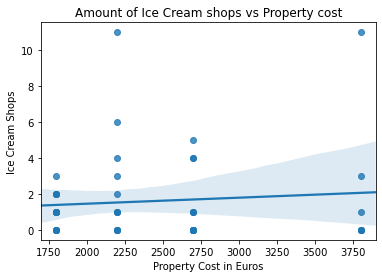

In [33]:
ax=sns.regplot(x='AVG Cost',y='IC Shops',data=df)
plt.title('Amount of Ice Cream shops vs Property cost')
plt.ylabel('Ice Cream Shops')
plt.xlabel('Property Cost in Euros')
plt.show()

**Well, that does show an extremely small correlation!** Time to see if there is a correlation with the flower shops. For that purpose, let's search again in foursquare: 

In [34]:
def getNearbyFlower(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4bf58dd8d48988d11b951735'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Stadtteil', 
                  'Stadtteil Latitude', 
                  'Stadtteil Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [35]:
Flower_venues = getNearbyFlower(names=df['Stadtteil'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Altstadt
Angermund
Benrath
Bilk
Carlstadt
Derendorf
Eller
Flehe
Flingern Nord
Flingern Süd
Friedrichstadt
Garath
Gerresheim
Golzheim
Grafenberg
Hafen
Hamm
Hassels
Heerdt
Hellerhof
Himmelgeist
Holthausen
Itter
Kaiserswerth
Kalkum
Knittkuhl
Lörick
Lichtenbroich
Lierenfeld
Lohausen
Ludenberg
Mörsenbroich
Niederkassel
Oberbilk
Oberkassel
Pempelfort
Rath
Reisholz
Stadtmitte
Stockum
Unterbach
Unterbilk
Unterrath
Urdenbach
Vennhausen
Volmerswerth
Wersten
Wittlaer


Time to use the auxiliary Dataframe _df2_ to get the amount of Flower venues now 

In [36]:
df2=Flower_venues.groupby('Stadtteil').count()
df2.reset_index(drop=False,inplace=True)
df2=df2[['Stadtteil','Venue']]
cabezas=['Stadtteil','Flower']
df2.columns=cabezas
df2.head()

,Stadtteil,Flower
0,Altstadt,6
1,Benrath,1
2,Bilk,3
3,Carlstadt,6
4,Derendorf,3


Now I will merge that to **df** and replace 'NaN' with the number zero again

In [37]:
df=df.merge(df2, how='left',on='Stadtteil')
df['Flower'].replace(np.nan,0, inplace=True)
df.head()

,Stadtbezirk,Stadtteil,Einwohner,Cost Binned,Cost per sm in Euro,Latitude,Longitude,Ice Cream Shop,AVG Cost,IC Shops,Flower
0,1,Altstadt,1906,Medium,2000 to 2400,51.225912,6.773567,0.030000,2200.0,11.0,6.0
1,5,Angermund,6061,High,2400 to 3000,51.328995,6.781416,0.000000,2700.0,0.0,0.0
2,9,Benrath,15772,Medium,2000 to 2400,51.163479,6.872734,0.071429,2200.0,3.0,1.0
3,3,Bilk,37275,Medium,2000 to 2400,51.202758,6.785101,0.000000,2200.0,2.0,3.0
4,1,Carlstadt,2210,Very High,3000 to 4700,51.222142,6.773394,0.020000,3800.0,11.0,6.0


**Finally, let's see if there is a correlation between the *actual amount* of Flower Shops in every *Stadtteil* and the Apartment cost in that area. For that purpose, I will plot again a regression line between the 2 variables for the last time:**

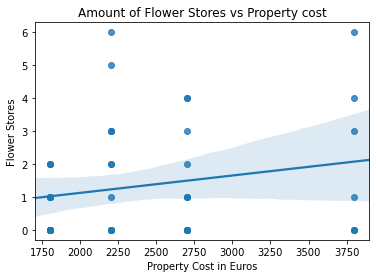

In [38]:
ax=sns.regplot(x='AVG Cost',y='Flower',data=df)
plt.title('Amount of Flower Stores vs Property cost')
plt.ylabel('Flower Stores')
plt.xlabel('Property Cost in Euros')
plt.show()

### **This time, there seems to be a small correlation!**

## C Results

### Clustering and visualization of _Stadtteil_,_Ice Cream Shops_ and _Flower Shops_

Following a similar procedure to that performed in point b.4, let's try to find if the new cluster map is more representative of actual differences between city areas 

In [39]:
kclusters = 8

df_grouped_clustering = df[['AVG Cost','IC Shops','Flower']]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([6, 4, 3, 3, 5, 3, 1, 4, 0, 4], dtype=int32)

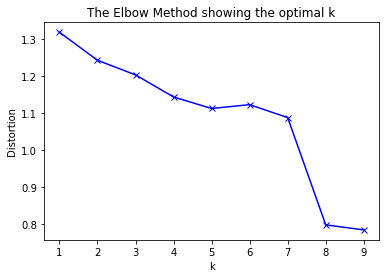

In [40]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(df_grouped_clustering)
    #kmeanModel.fit(istanbul_grouped_clustering)
    distortions.append(sum(np.min(cdist(df_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1)) / df_grouped_clustering.shape[0])

#There are different metric distance function for spatial distance. 
#I choose correlation instaed of euclidean because the canberra function gives me more clear view of elbow break point.

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [41]:
df.insert(0, 'Cluster Labels', kmeans.labels_)
df.head()

,Cluster Labels,Stadtbezirk,Stadtteil,Einwohner,Cost Binned,Cost per sm in Euro,Latitude,Longitude,Ice Cream Shop,AVG Cost,IC Shops,Flower
0,6,1,Altstadt,1906,Medium,2000 to 2400,51.225912,6.773567,0.030000,2200.0,11.0,6.0
1,4,5,Angermund,6061,High,2400 to 3000,51.328995,6.781416,0.000000,2700.0,0.0,0.0
2,3,9,Benrath,15772,Medium,2000 to 2400,51.163479,6.872734,0.071429,2200.0,3.0,1.0
3,3,3,Bilk,37275,Medium,2000 to 2400,51.202758,6.785101,0.000000,2200.0,2.0,3.0
4,5,1,Carlstadt,2210,Very High,3000 to 4700,51.222142,6.773394,0.020000,3800.0,11.0,6.0


In [42]:
map_clusters2 = folium.Map(location=[latitudeD, longitudeD], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Stadtteil'], df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2

This map is actually similar to a map that shows different property values per Stadtteil available in [the next website](https://www.jll.de/content/dam/jll-com/documents/pdf/research/emea/germany/en/Residential-City-Profile-Dusseldorf-JLL-Germany.pdf)

## D. Discussion

Based on the findings shown in the previous section, there appears to be a correlation between the amount of Ice cream shops and flower stores to the property cost. The correlation is small, and therefore, it’s a weak one. It stands to reason that there will be better indicators of property cost than the ones selected. But as a foreigner in this city and in Germany, I must admit to being curious about the amount of Ice cream and flower shops.


## F. Conclusion

Duesseldorf is a relatively large city in Germany, though it covers a fairly large area, meaning it has low population density. Therefore, there are many Stadtteil with very low population, which in turn means there are very few stores.

Even though one might not expect to find a correlation between the property cost and the amount of Stores such as Flower or Ice Cream Parlors, it stands to reason that there will be more stores in general in Neighborhoods with more purchasing power. That raises the question: are there more stores because there is more purchasing power, or is the property value higher in part, because there are more stores? It is also important for investors to know where there might be more purchasing power to know where to locate a store.

There is also room for improvement. One possibility would be to use the Average property price per square meter instead of a binned value. That would imply scrapping real estate websites for the data. Another interesting idea would be to add more characteristic German stores to the clustering to find a better correlation.

It may also be interesting to use a choropleth map to visualize the results, as in the link provided at the end of the previous section.


## G. Acknowledges:

I would like to thank my wife for sharing with me this journey, both in Data Science and moving to Germany.

## H. References:

a. [Wikipedia Duesseldorf](https://de.wikipedia.org/wiki/Liste_der_Stadtteile_von_D%C3%BCsseldorf)

b. [Forsquare API](https://developer.foursquare.com/docs/build-with-foursquare/categories/)

c. [JLL Research](https://www.jll.de/content/dam/jll-com/documents/pdf/research/emea/germany/en/Residential-City-Profile-Dusseldorf-JLL-Germany.pdf)

